# Численное решение уравнения переноса

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Функция решает уравнение переноса заданной схемы и также возвращает массив ошибок L2 от аналитического решения

### буду решать уравнение переноса для гауссиана

In [21]:
def solve_pde(scheme, N, C=0.5, L=20, a=1, t_end=2):
    dx = (2 * L) / N  # Область x ∈ [-L, L]
    dt = C * dx / a
    nt = int(round(t_end / dt))
    t_final = nt * dt
    
    x = np.linspace(-L, L, N + 1)
    u0 = np.exp(-x**2 / 2)  # Начальное условие
    u = u0.copy()
    u_history = [u0.copy()]
    t_values = [0.0]

    for _ in range(nt):
        if scheme == 'upwind':
            u_new = u.copy()
            u_new[1:] = u[1:] - C * (u[1:] - u[:-1])
            u_new[0] = 0  # Граничное условие
            u = u_new
        elif scheme == 'lax_wendroff':
            u_new = u.copy()
            u_new[1:-1] = u[1:-1] - 0.5*C*(u[2:] - u[:-2]) + 0.5*C**2*(u[2:] - 2*u[1:-1] + u[:-2])
            u_new[0] = 0
            u_new[-1] = u[-2]
            u = u_new
        elif scheme == 'central':
            u_new = u.copy()
            u_new[1:-1] = u[1:-1] - 0.5*C*(u[2:] - u[:-2])  # Центральная схема
            u_new[0] = 0
            u_new[-1] = u[-2]
            u = u_new
        
        u_history.append(u.copy())
        t_values.append(t_values[-1] + dt)

    u_analytical = np.exp(-(x - a * t_final)**2 / 2)
    error = np.sqrt(dx * np.sum((u - u_analytical)**2))
    
    return x, u_history, u_analytical, t_values, error


## Визуализация решений в моменты времени 0, 5, 10, 15, 20

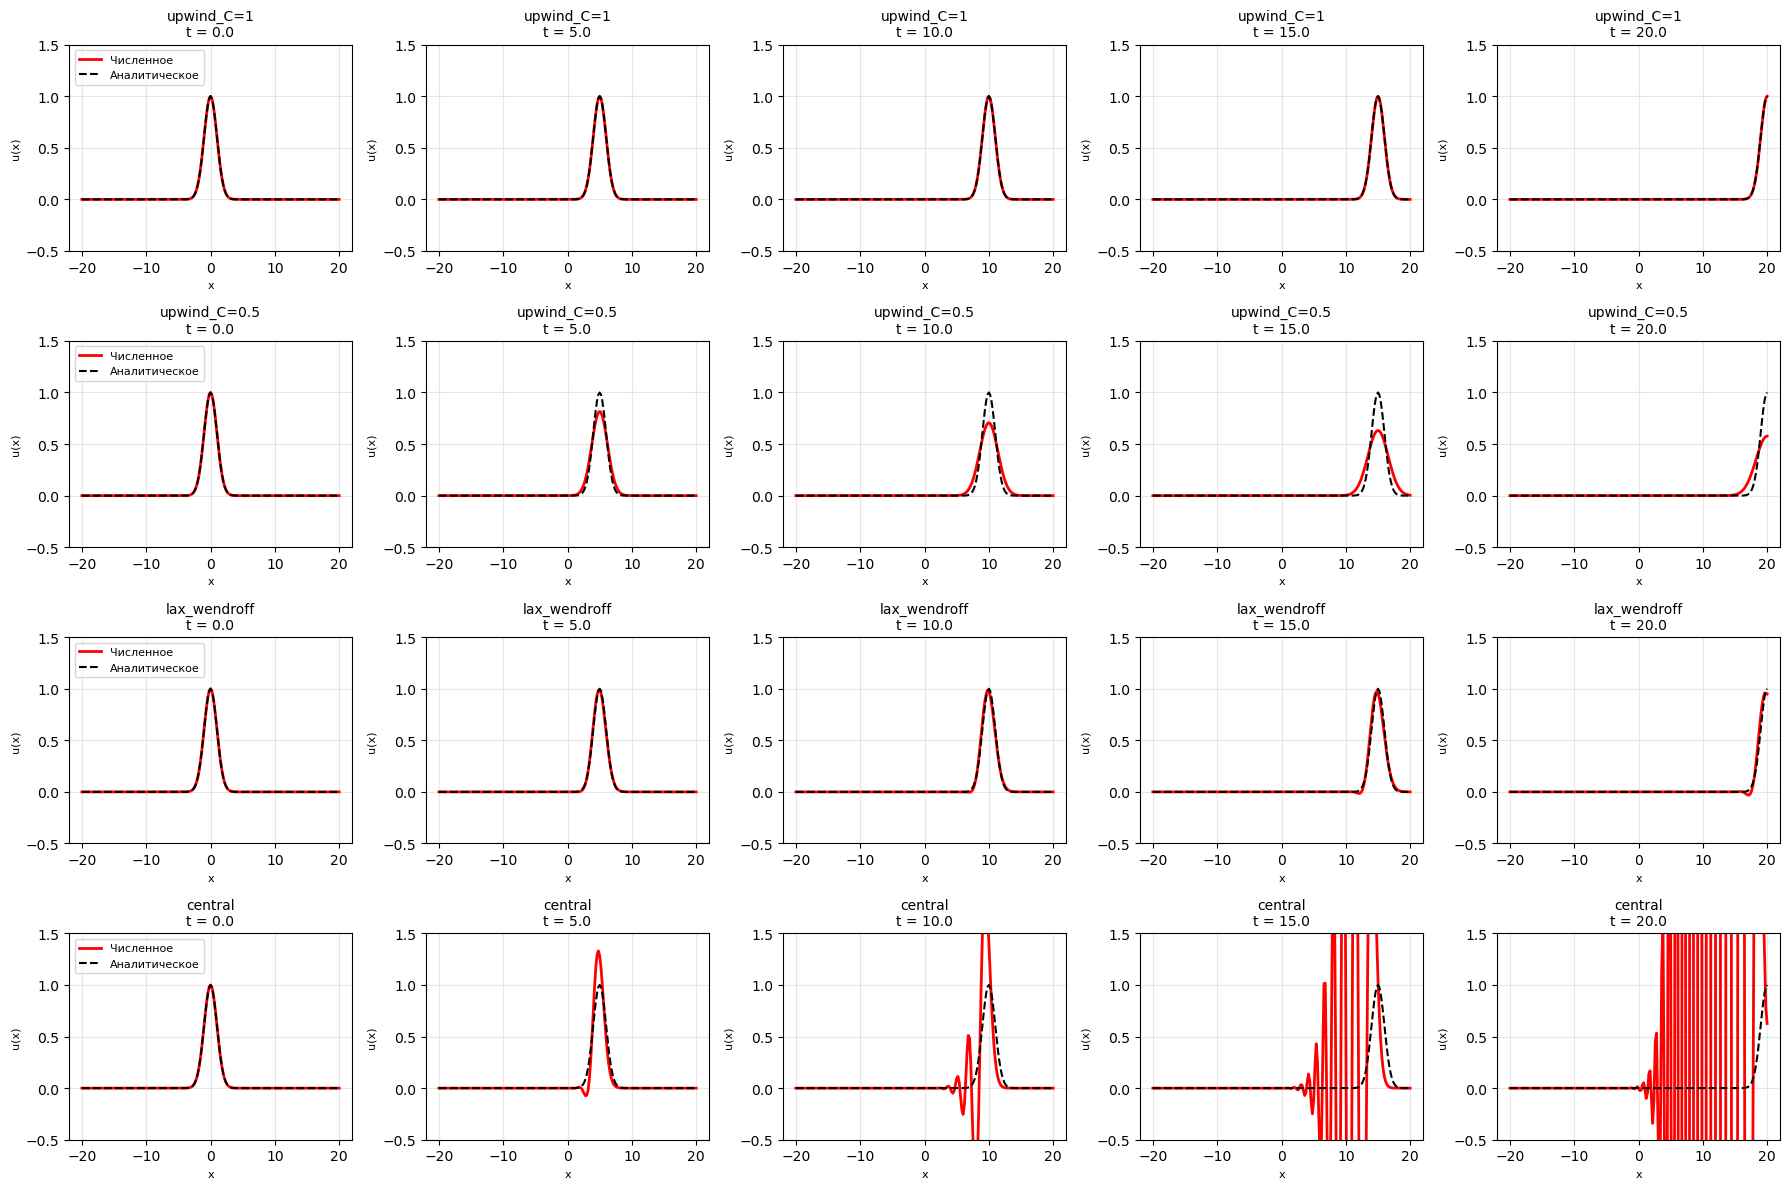

In [23]:
schemes = ['upwind_C=1', 'upwind_C=0.5', 'lax_wendroff', 'central']
time_moments = [0, 5, 10, 15, 20]
N = 200
L = 20
t_end = 20

fig, axes = plt.subplots(len(schemes), len(time_moments), figsize=(18, 12))

for row, scheme in enumerate(schemes):
    if 'upwind' in scheme:
        C = 1.0 if 'C=1' in scheme else 0.5
        scheme_type = 'upwind'
    else:
        scheme_type = scheme
        C = 0.5

    # Решаем уравнение
    x, u_history, u_anal, t_values, error = solve_pde(
        scheme=scheme_type, 
        N=N, 
        C=C, 
        L=L, 
        t_end=t_end
    )
    t_values = np.array(t_values)
    
    indices = [np.abs(t_values - t).argmin() for t in time_moments]
    
    for col, idx in enumerate(indices):
        ax = axes[row, col]
        t_actual = t_values[idx]
        
        ax.plot(x, u_history[idx], 'r-', linewidth=2, label='Численное')
        u_anal = np.exp(-(x - 1 * t_actual)**2 / 2)
        ax.plot(x, u_anal, 'k--', linewidth=1.5, label='Аналитическое')
        
        ax.set_title(f'{scheme}\nt = {t_actual:.1f}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel('u(x)', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 1.5)
        
        if col == 0:
            ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

## Исследование сходимости

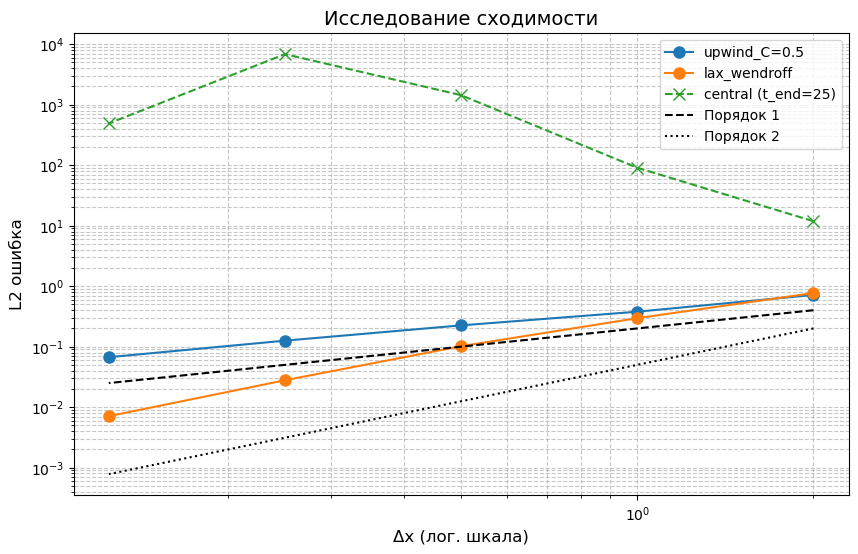

In [25]:

N_values = [20, 40, 80, 160, 320]
errors = {'upwind_C=0.5': [], 'lax_wendroff': [], 'central': []}

for scheme in errors:
    if 'upwind' in scheme:
        C = 0.5
        scheme_type = 'upwind'
        t_end = 2.0
    elif scheme == 'central':
        C = 0.5
        scheme_type = 'central'
        t_end = 25
    else:
        C = 0.5
        scheme_type = scheme
        t_end = 2.0

    for N in N_values:
        x, u_history, u_anal, t_values, error = solve_pde(
            scheme=scheme_type, 
            N=N, 
            C=C, 
            L=20, 
            t_end=t_end
        )
        t_values = np.array(t_values) 
        errors[scheme].append(error)

# График сходимости
dx_values = [(2 * 20) / N for N in N_values]
plt.figure(figsize=(10, 6))

for scheme in errors:
    if scheme == 'central':
        plt.loglog(dx_values, errors[scheme], 'x--', markersize=8, label=f'{scheme} (t_end=25)')
    else:
        plt.loglog(dx_values, errors[scheme], 'o-', markersize=8, label=scheme)

plt.loglog(dx_values, [0.2 * dx**1 for dx in dx_values], 'k--', label='Порядок 1')
plt.loglog(dx_values, [0.05 * dx**2 for dx in dx_values], 'k:', label='Порядок 2')

plt.xlabel('Δx (лог. шкала)', fontsize=12)
plt.ylabel('L2 ошибка', fontsize=12)
plt.title('Исследование сходимости', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

## схема "уголок" имеет линейный характер сходимости(в теории), что подтверждается результатами вычислений. Аналогично со схемой Лакса-Вендроффа(имеет квадратичную сходимость).
## Центральная схема(прямоугольник) не сходится